## Orientation Recovery with Perfect and Perturbed Distances

In [1]:
ROOT_DIR = "../.."

In [24]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [19]:
import os
import h5py
import numpy as np   
import matplotlib.pyplot as plt
import sys
sys.path.append(ROOT_DIR) 
#from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.angle_recovery import train_angle_recovery
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec
from cryoem.helpers import train_val_test_split
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl
from cryoem.conversions import quaternion2euler

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2629436883490446887
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11131505856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 20736306143440160
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
]


### Read data

In [5]:
# full sphere coverage with non-uniform distribution
projections_filename = "../../data/5j0n_full.h5"

# load structures
data_full_5k = h5py.File(projections_filename, 'r')
angles_true = np.array(data_full_5k['Angles'], dtype=np.float32)
projections = np.array(data_full_5k['Projections'], dtype=np.float32)
label = "Full-coverage, Euler uniform"


print(f"{angles_true.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [6]:
train_idx, val_idx, test_idx = train_val_test_split(indices=range(len(projections)), file_name="../../data/indices.npz")

### Distance function 

In [7]:
def d_p(in1, in2, sigma=0.0):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=sigma, dtype=tf.float64)
    return norm_distr  

### Orientation Recovery

In [8]:
sigma = 0.0

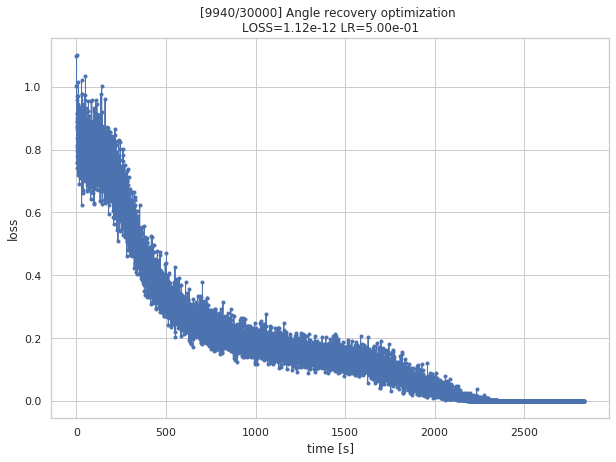

Shape of projections: (1650, 4)step 3000/30000 (775s): loss = 2.01e-01
step 6000/30000 (1608s): loss = 9.50e-02
step 9000/30000 (2529s): loss = 3.73e-08
step 9940/30000 (2833s): loss = 3.52e-12



In [12]:
q_predicted, losses, q_all = train_angle_recovery(steps=30000, 
                             batch_size=256, 
                             in_data=angles_true[test_idx], 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,
                             file_name=f"../../data/angle_recovery_with_euclidean")

In [13]:
data = np.load(f"../../data/angle_recovery_with_euclidean.npz")

q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]
angles_predicted = quaternion2euler(q_predicted)

### Angle Alignment

m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [2.26706458 2.96843607 1.68547773 2.84891888 2.27181548 3.06378368] 
loss_first= 2.691539013540119 
trajectory_last= [0. 0. 0. 0. 0. 0.] 
loss_last= 5e-324


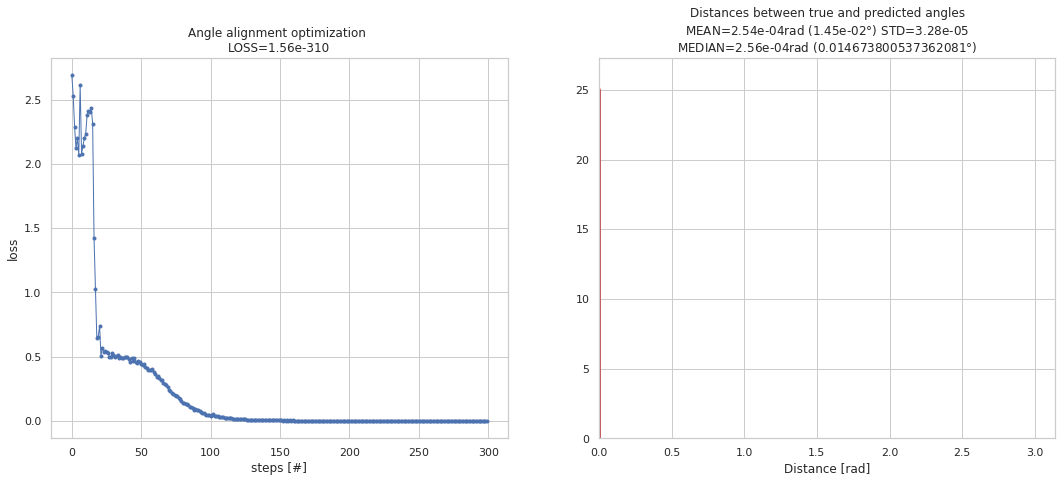

In [14]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true[test_idx], 
                                                        angles_predicted=angles_predicted)

In [15]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)
angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

np.save(f"../../data/angles_predicted_euclidean_rotated", angles_predicted_rotated)

In [18]:
plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=200, connections=False, selected=None)

In [20]:
plot_iterations_rotvec(collect_data, angles_true[test_idx], interval=200)

### Summary for Perturbed Distances

In [21]:
labelpad = 6
label_size = 30
tick_size=20
TEST_COLOR_EOR = "red"
TEST_COLOR_LOR = "blue"

#### $L_{OR}$ and $E_{OR}$ w.r.t. Variance of Noise in `5j0n`

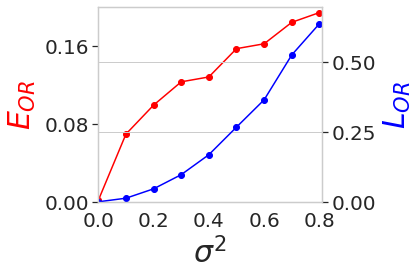

In [22]:
variances = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
losses = np.array([9.26e-09, 1.29e-02, 4.65e-02, 9.74e-02, 1.69e-01, 2.68e-01, 3.66e-01, 5.27e-01,6.39e-01])
aa_losses = np.array([1.47e-03, 6.94e-02, 9.91e-02, 1.23e-01, 1.28e-01, 1.57e-01, 1.62e-01, 1.84e-01, 1.94e-01])

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('$\sigma^2$', fontsize=label_size, labelpad=labelpad)
ax.plot(variances, aa_losses, marker="o", color=TEST_COLOR_EOR)
ax.set_ylabel('$E_{OR}$', color=TEST_COLOR_EOR, fontsize=label_size, labelpad=labelpad)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_ylim(0, 0.2)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid()
ax.set_xlim(0, 0.81)

ax2 = ax.twinx()
ax2.plot(variances, losses, marker="o", color=TEST_COLOR_LOR)
ax2.set_ylabel('$L_{OR}$', color=TEST_COLOR_LOR, fontsize=label_size, labelpad=labelpad)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.set_ylim(0, 0.7)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
plt.show()

#### $L_{OR}$ and $E_{OR}$ w.r.t. Variance of Noise in `5a1a`

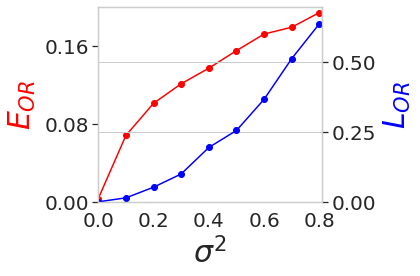

In [23]:
variances = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
losses = np.array([1.42e-08, 1.42e-02, 5.24e-02, 1.00e-01, 1.95e-01, 2.56e-01, 3.68e-01, 5.14e-01, 6.39e-01])
aa_losses = np.array([3.33e-03, 6.81e-02, 1.01e-01, 1.21e-01, 1.37e-01, 1.55e-01, 1.72e-01, 1.79e-01, 1.94e-01])

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('$\sigma^2$', fontsize=label_size, labelpad=labelpad)
ax.plot(variances, aa_losses, marker="o", color=TEST_COLOR_EOR)
ax.set_ylabel('$E_{OR}$', color=TEST_COLOR_EOR, fontsize=label_size, labelpad=labelpad)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_ylim(0, 0.2)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid()
ax.set_xlim(0, 0.81)

ax2 = ax.twinx()
ax2.plot(variances, losses, marker="o", color=TEST_COLOR_LOR)
ax2.set_ylabel('$L_{OR}$', color=TEST_COLOR_LOR, fontsize=label_size, labelpad=labelpad)

ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.set_ylim(0, 0.7)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
plt.show()